# Model evaluation

## Simulating fMRI signal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from nilearn.glm.first_level import glover_hrf, spm_hrf
from nilearn.glm.first_level.hemodynamic_models import _gamma_difference_hrf
import scipy.interpolate
import nibabel as nib
from scipy.stats import multivariate_normal

In [2]:
# Load stimulus
data_directory = '/BULK/LABDATA/openneuro/ds004698/'
sub_id = 'sub-01'
aperture = scipy.io.loadmat(data_directory + 'derivatives/prf-estimation/stimuli/'
                            'task-logbar_run-1_desc-down_aperture.mat')
tr = 1.2  # Repetition time in seconds

# Load empirical data
fmri_data = []
for run in ['run-1']:
    for ses in ['ses-01']:
        fmri_data_tmp = nib.load(data_directory + 'derivatives/prf-estimation/' + sub_id +
                                '/func/sub-01_' + ses + '_task-fixedbar_' + run + '_hemi-L_space-fsnative_desc-preproc_bold.func.gii').agg_data()
        fmri_data_tmp = np.array(fmri_data_tmp)
        fmri_data.append(fmri_data_tmp)
fmri_data = np.array(fmri_data[0])
# mask_lh = nib.load('/home/ribeiro/Projects/deepRetinotopy_validation/datasets/'
#                             'ds004698/derivatives/freesurfer/' + sub_id + 'deepRetinotopy/'
#                             'sub-01.fs_V1-3_mask_lh.func.gii').agg_data()

# Predicted parameters
polar_angle = nib.load(data_directory + 'derivatives/freesurfer/' + sub_id + '/deepRetinotopy/sub-01.predicted_polarAngle_model.lh.native.func.gii').agg_data()
# transform polar angle 
eccentricity = nib.load(data_directory + 'derivatives/freesurfer/' + sub_id + '/deepRetinotopy/sub-01.predicted_eccentricity_model.lh.native.func.gii').agg_data()
pRFsize = nib.load(data_directory + 'derivatives/freesurfer/' + sub_id + '/deepRetinotopy/sub-01.predicted_pRFsize_model.lh.native.func.gii').agg_data()

# Empirical data
x_empirical = nib.load(data_directory + 'derivatives/prf-estimation/' + sub_id + '/prfs/'
                       'sub-01_ses-all_task-logbar_hemi-L_space-fsnative_prf/sub-01_ses-all_task-logbar_hemi-L_space-fsnative_x0.gii').agg_data()
y_empirical = nib.load(data_directory + 'derivatives/prf-estimation/' + sub_id + '/prfs/'
                       'sub-01_ses-all_task-logbar_hemi-L_space-fsnative_prf/sub-01_ses-all_task-logbar_hemi-L_space-fsnative_y0.gii').agg_data()
eccentricity_empirical = nib.load(data_directory + 'derivatives/prf-estimation/' + sub_id + '/prfs/'
                       'sub-01_ses-all_task-logbar_hemi-L_space-fsnative_prf/sub-01_ses-all_task-logbar_hemi-L_space-fsnative_eccen.gii').agg_data()
vexpl_empirical = nib.load(data_directory + 'derivatives/prf-estimation/' + sub_id + '/prfs/'
                       'sub-01_ses-all_task-logbar_hemi-L_space-fsnative_prf/sub-01_ses-all_task-logbar_hemi-L_space-fsnative_vexpl.gii').agg_data()
pRFsize_empirical = nib.load(data_directory + 'derivatives/prf-estimation/' + sub_id + '/prfs/'
                       'sub-01_ses-all_task-logbar_hemi-L_space-fsnative_prf/sub-01_ses-all_task-logbar_hemi-L_space-fsnative_sigma.gii').agg_data()



In [7]:
np.where(vexpl_empirical==np.max(vexpl_empirical))

(array([8160]),)

(0.0, 1000.0)

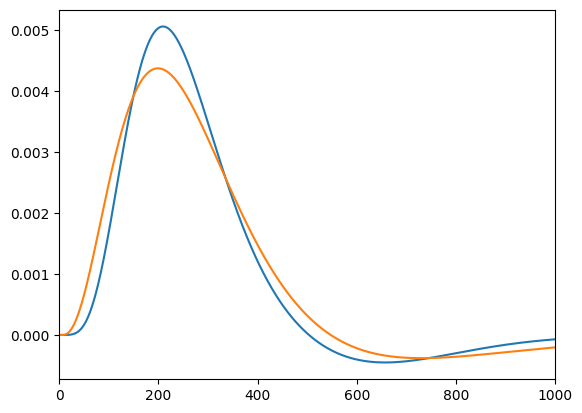

In [8]:
stim_time = aperture['stim']['t'][0][0]
t_max = int(np.max(stim_time)) + 1
hrf_glover = glover_hrf(tr, oversampling=50, time_length=t_max)
hrf_spm = _gamma_difference_hrf(tr=tr, time_length=t_max)
hrf_gamma = _gamma_difference_hrf(tr=tr, time_length=t_max, onset=.1, 
                                  delay = 6.68, undershoot=14.66, dispersion=1.82, u_dispersion=3.15,
                                  ratio=1/3.08)

# plt.plot(hrf_glover, label='glover')
plt.plot(hrf_spm, label='spm')
plt.plot(hrf_gamma, label='gamma')
plt.xlim([0, 1000])

In [9]:
def variance_explained(aperture, fmri_data, tr, y_coord, x_coord, pRFsize):

    # Get the stimulus parameters
    stim_time = aperture['stim']['t'][0][0]

    # Generate HRF
    t_max = int(np.max(stim_time)) + 1
    hrf = _gamma_difference_hrf(tr=tr, time_length=t_max, onset=.1, 
                                  delay = 6.68, undershoot=14.66, dispersion=1.82, u_dispersion=3.15,
                                  ratio=1/3.08)
    # hrf = _gamma_difference_hrf(tr=tr, time_length=t_max, onset=.1, delay = 6.68, undershoot=14.66, dispersion=1.82, u_dispersion=3.15, ration=3.08)

    # Interpolate HRF to match stimulus time
    hrf_function = scipy.interpolate.interp1d(np.linspace(0, t_max, len(hrf)), hrf)
    new_hrf = hrf_function(stim_time)

    # Aperture data
    data = aperture['stim']['img'][0][0]

    
    normalized_fmri_data = (fmri_data - np.mean(fmri_data)) / np.std(fmri_data)
    x, y = aperture['stim']['x'][0][0], aperture['stim']['y'][0][0]
    pos = np.dstack((x, y))
    
    variance_explained_ = []
    for i in range(len(x_coord)):
        X0 = x_coord[i]
        Y0 = y_coord[i]
        sigma = pRFsize[i]
        if sigma > 0:
            
            mean = [X0, Y0]
            covariance = [[sigma, 0], [0, sigma]] 

            rv = multivariate_normal(mean, covariance)
            gaussian_2d = rv.pdf(pos)

            # Determine the overlap between the stimulus and the pRF and calculate the spatial summation
            overlap = data * gaussian_2d[:,:,np.newaxis]
            overlap = np.sum(overlap, axis=(0,1))

            # Convolve the timeseries from the previous step with the HRF
            predicted_signal = np.convolve(overlap, new_hrf[0])[0:len(overlap)]

            # Interpolate the predicted signal to match the fmri data
            bold_func = scipy.interpolate.interp1d(np.linspace(0, t_max, len(predicted_signal)), predicted_signal)
            predicted_signal = bold_func(np.linspace(0, t_max, int(t_max/tr)))
            normalized_predicted_signal = (predicted_signal - np.mean(predicted_signal)) / np.std(predicted_signal)
            # plt.plot(normalized_predicted_signal)
            corr = np.corrcoef(normalized_predicted_signal, normalized_fmri_data[i])[0,1]
            if corr is np.nan:
                print(f'X0: {X0}, Y0: {Y0}, sigma: {sigma}')
            variance_explained_.append(corr**2)
        else:
            continue
    return variance_explained_

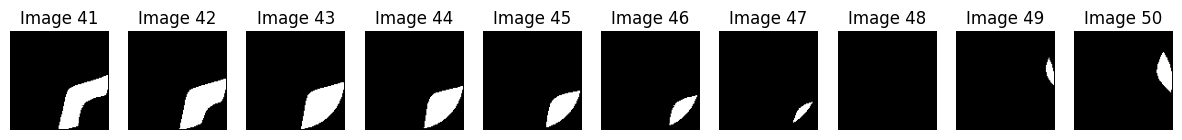

In [10]:
aperture = scipy.io.loadmat('/BULK/LABDATA/openneuro/ds004698/derivatives/prf-estimation/stimuli/'
                            'task-logbar_run-1_desc-down_aperture.mat')

# Get the stimulus parameters
stim_time = aperture['stim']['t'][0][0]

# Generate HRF
t_max = int(np.max(stim_time)) + 1
hrf = _gamma_difference_hrf(tr=tr, time_length=t_max, onset=.1, 
                                  delay = 6.68, undershoot=14.66, dispersion=1.82, u_dispersion=3.15,
                                  ratio=1/3.08)

# Interpolate HRF to match stimulus time
delta_t = (t_max - np.min(stim_time))/len(hrf)
hrf_function = scipy.interpolate.interp1d(np.linspace(0, t_max, len(hrf)), hrf)
new_hrf = hrf_function(stim_time)

# Aperture data
data = aperture['stim']['img'][0][0]
fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # Display 5 images for example
for i in range(40,50):
    axes[i-40].imshow(data[:, :, i], cmap='gray')
    axes[i-40].set_title(f'Image {i+1}')
    axes[i-40].axis('off')
plt.show()

X0: 0.865645706653595, Y0: -0.41978347301483154, sigma: 0.1575329750776291


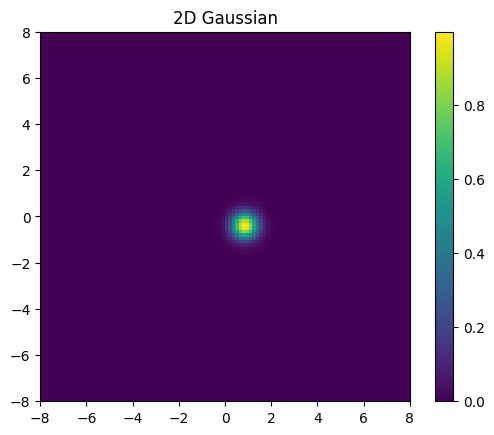

In [11]:
i = 8160

normalized_fmri_data = (fmri_data - np.mean(fmri_data)) / np.std(fmri_data)

x, y = aperture['stim']['x'][0][0], aperture['stim']['y'][0][0]
pos = np.dstack((x, y))

correlation = []

X0 = x_empirical[i]
Y0 = y_empirical[i]
sigma = pRFsize_empirical[i]

print(f'X0: {X0}, Y0: {Y0}, sigma: {sigma}')
mean = [X0, Y0]
covariance = [[sigma, 0], [0, sigma]] 

rv = multivariate_normal(mean, covariance)
gaussian_2d = rv.pdf(pos)

# Plot 2D Gaussian
plt.imshow(gaussian_2d, extent=(-8, 8, -8, 8), cmap='viridis')
plt.colorbar()
plt.title('2D Gaussian')
plt.show()

0.4114493630003778


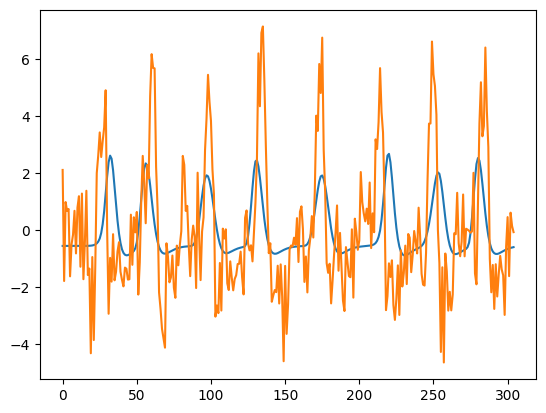

In [12]:
# Determine the overlap between the stimulus and the pRF and calculate the spatial summation
overlap = data * gaussian_2d[:,:,np.newaxis]
# plt.imshow(overlap_1[:,:,500], cmap='gray')
overlap = np.sum(overlap, axis=(0,1))

# Convolve the timeseries from the previous step with the HRF
predicted_signal = np.convolve(overlap, new_hrf[0])[0:len(overlap)]

# plt.plot(overlap, label='Overlap 1')

# Interpolate the predicted signal to match the fmri data
bold_func = scipy.interpolate.interp1d(np.linspace(0, t_max, len(predicted_signal)), predicted_signal)
predicted_signal = bold_func(np.linspace(0, t_max, int(t_max/tr)))
normalized_predicted_signal = (predicted_signal - np.mean(predicted_signal)) / np.std(predicted_signal)

corr = np.corrcoef(normalized_predicted_signal, normalized_fmri_data[i])[0,1]
print(corr)

plt.plot(normalized_predicted_signal, label='Predicted signal')
plt.plot(normalized_fmri_data[i], label='Empirical data')

# Debug HRF from braincoder

In [ ]:
from scipy.stats import gamma
dt = tr/1

onset = 0
onset = 0.1
delay = 6
delay = 6.68
dispersion = 1
dispersion = 1.82


undershoot = 16
undershoot = 14.66
u_dispersion = 1
u_dispersion = 3.15

ratio = .167
ratio=1/3.08


time_stamps = np.linspace(
        0, t_max, np.rint(float(t_max) / dt).astype(int)
    )
time_stamps -= onset
gamma_1 = gamma.pdf(time_stamps, delay / dispersion, loc=dt, scale=dispersion)
gamma_2 = gamma.pdf(time_stamps, undershoot/ u_dispersion, loc=dt, scale=u_dispersion)

hrf = gamma_1 - ratio * gamma_2
hrf /= hrf.sum()
# plt.plot(gamma_1, label='gamma')
# plt.plot(gamma_2, label='gamma2')
plt.plot(hrf, label='gamma')


def gamma_pdf(t, a, d):
    """Compute the gamma probability density function at t."""
    return t**(a - 1) * np.exp(-t / d) / (d** a * np.exp(scipy.special.gammaln(a)))

def spm_hrf(t, a1=6., d1=1., a2=16., d2=1., c=1./6):
    """Compute the SPM canonical HRF at time points t."""
    hrf = gamma_pdf(t, a1, d1) - c * gamma_pdf(t, a2, d2)
    return hrf

braincoder_hrf = spm_hrf(time_stamps, a1=delay/dispersion, d1=dispersion,
                             a2=undershoot/u_dispersion, d2=u_dispersion, c=ratio)
# braincoder_hrf = spm_hrf(time_stamps, a1=delay, d1=dispersion,
#                              a2=undershoot, d2=u_dispersion, c=ratio)
plt.plot(braincoder_hrf*1.7, label='braincoder')
plt.xlim([-0.1, 50])